In [1]:
# os
import os
import glob

# data
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, sobel
from scipy import signal

# image processing
from PIL import Image
from PIL.TiffTags import TAGS
from scipy.ndimage import gaussian_filter, sobel
from skimage import io, exposure, morphology, filters
import cv2

# additionally exif needs to be installed (some issues with dependencies) https://pypi.org/project/Exif-python/ 

### Defining functions

In [2]:
def local_variance_filter(image,radius=20):
   # time1 = time.time()
    kernel = morphology.disk(radius)
    variance = np.zeros(image.shape)
    for i in np.arange(radius,image.shape[0]-radius):
        for j in np.arange(radius,image.shape[1]-radius):
            pixels = image[i-radius:i+radius+1,j-radius:j+radius+1] * kernel
            variance[i,j] = np.var(pixels[kernel==1])
   # print(str(time.time()-time1)+" s ")
    return variance

In [3]:
# Getting metadata for small image (resolution)
def get_metadata(im_small):
    exifdata = im_small.getexif()
    for tag_id in exifdata:
        # get the tag name, instead of human unreadable tag id
        tag = TAGS.get(tag_id, tag_id)
        data = exifdata.get(tag_id)
        # decode bytes
        if isinstance(data, bytes):
            data = data.decode()

        if tag == 'ImageWidth':
            im_w = data
            print(f"{tag}: {data}")
        elif tag == 'ImageLength':
            im_h = data
            print(f"{tag}: {data}")
        elif tag == 'XResolution':
            x_res = data
            print(f"{tag}: {data}")
        elif tag == 'YResolution':
            y_res = data
            print(f"{tag}: {data}")

    
    return im_w, im_h, x_res, y_res

In [4]:
def distance_two_images(im1, im2):
    """ the euclidean square distance of two images in terms of intensity is calculated
    :im1 np.array of the big image
    :im2 np.array of the small image   """
    
    (height, width) = np.shape(im1)
    (h, w) = np.shape(im2)
    d = np.empty((height - h, width - w))
    
    for row in range(height - h):
        for col in range(width - w):
            d[row,col] = np.sum( np.square( np.subtract(im1[0+row : h+row, 0+col : w+col] , im2) ))
    
    return d

In [5]:
def position_of_min(d):
    """ determine the position of minimum
    :d np.array of distances """
    
    result = np.where(d == np.amin(d))
    print("the minimum distance is: ", np.amin(d))
    print('Tuple of arrays returned : ', result)
    
    return result

In [6]:
def max_cross_corr(im1,im2): #im1 bigger than im2
    C=signal.correlate(im1,im2) #compute cross correlation
    x=np.where(C==np.max(C))[0]-(im2.shape[0]-1)
    y=np.where(C==np.max(C))[1]-(im2.shape[1]-1)
    return x,y #return where im2 should be put in im1

### Defining parameters

In [7]:
cells = [''] # this should be a list (TODO: adapt code for multi-cell batch processing)
small_im_type = 'YM/qi-fit-2022.03.22-16.21.33.706' # can be 'TP' for 'topo' or 'YM'
large_im_type = 'sample_projection' # can be 'BF' or 'IC' for 'ICM'

In [8]:
# Setting parameters
i = 0

data_folder = '/NUS_plant_meristem/'

px_large = 240.5e-9  #(Hamamatsu camera - for ICM images) - this will determine rescaling (it will be rounded to integer based on the resolution of the small image that is encoded in the tif metadata)

var_filt_radius = 3 # radius for variance filtering
perc_threshold = 90 # percentile threshold for binarsising filtered result

thr_overlay_vis = 12 # threshold for visualising overlay (applied to small image)


### Loading data

In [9]:
f'{cells[i]}{small_im_type}*.tif'

'YM/qi-fit-2022.03.22-16.21.33.706*.tif'

In [10]:
im_small_filename = glob.glob(os.getcwd() + data_folder + f'{cells[i]}{small_im_type}*.tif')[0]
im_large_filename = glob.glob(os.getcwd() + data_folder + f'{cells[i]}{large_im_type}*.tif')[0]

In [11]:
# loading
im_small = Image.open(im_small_filename)
im_large = Image.open(im_large_filename)

# loading metadata (small)
im_w, im_h, x_res, y_res = get_metadata(im_small)

im_small_np = np.rot90(np.asarray(im_small), k=1)
im_large_np = np.fliplr(np.asarray(im_large))

# dealing with resolution
im_w, im_h = im_large.size
px_small=1/(float(x_res)) *10**(-9)
resc_rat = (px_small/px_large)

print('\nRounded ratio between resolutions: ', resc_rat)

# resizing
im_large_rs = im_large.resize([int(im_w/resc_rat), int(im_h/resc_rat)])
im_large = im_large_rs
im_large_np = np.fliplr(np.asarray(im_large))

ImageWidth: 64
ImageLength: 64
XResolution: 0.004257267109178301
YResolution: 0.004257267109178301

Rounded ratio between resolutions:  0.9766838799096864


In [12]:
im_large_np.shape

(1048, 1048)

Text(0.5, 1.0, 'Small image px histogram')

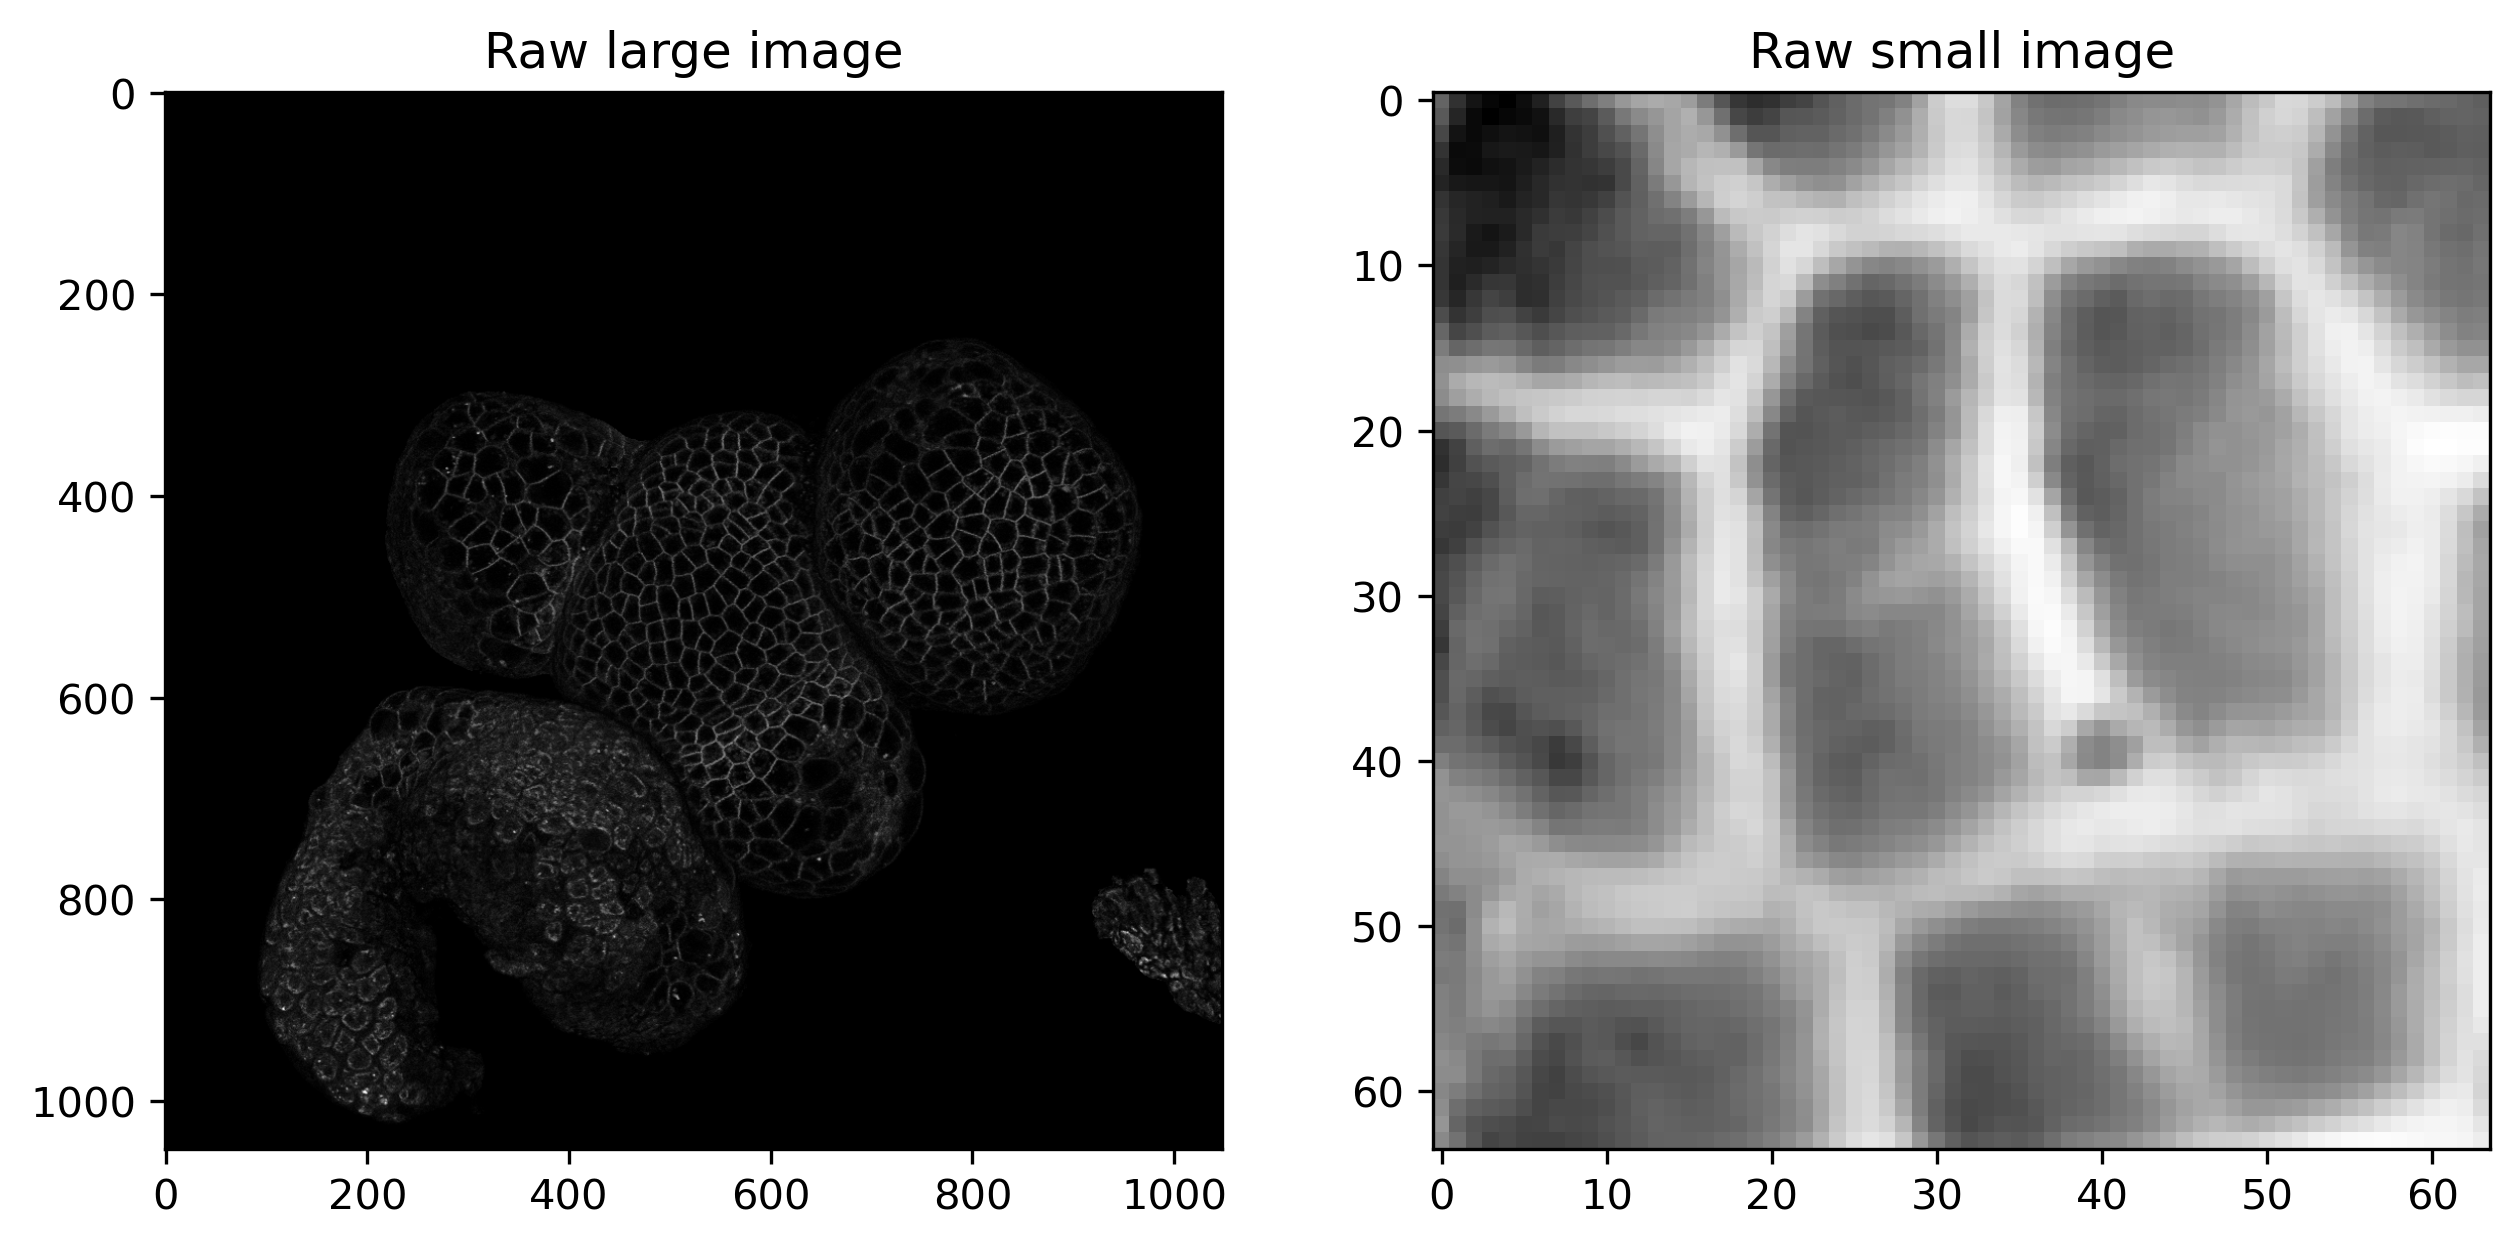

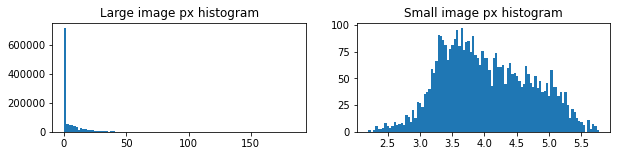

In [13]:
# plotting original images and their histograms
_,axs = plt.subplots(1,2, figsize=(10,20),dpi=300)
axs[0].imshow(im_large_np, cmap='Greys_r')
axs[1].imshow(im_small_np, cmap='Greys_r')
axs[0].set_title('Raw large image')
axs[1].set_title('Raw small image')

_,axs = plt.subplots(1,2, figsize=(10,2))
axs[0].hist(im_large_np.flatten(), 100)
axs[1].hist(im_small_np.flatten(), 100);
axs[0].set_title('Large image px histogram')
axs[1].set_title('Small image px histogram')



### Preprocessing small image

In [14]:
li_thr = filters.threshold_li(im_small_np)
print(li_thr)

3.993508


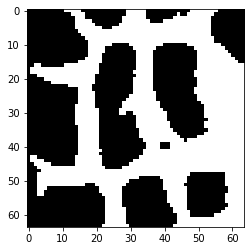

In [15]:
im_small_np_thr = im_small_np>li_thr
plt.imshow(im_small_np_thr, 'Greys_r')

### Preprocessing large image

Text(0.5, 1.0, 'Truncated px histogram based on percentile threshold')

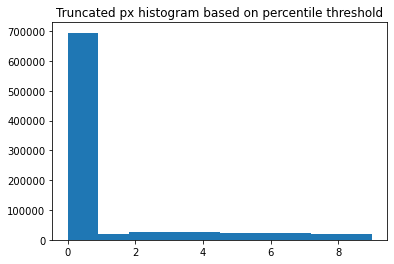

In [16]:
#im_large_thr = filters.threshold_li(im_large_np)
im_large_thr = 10

var = im_large_np
# var = local_variance_filter(im_large_np, radius=var_filt_radius)
# perc = np.percentile(var, perc_threshold)

var_thr = var.copy()
var_thr = var > im_large_thr
# var_thr[var_thr < perc] = 0
# var_thr[var_thr >= perc] = 1

plt.hist(var.flatten()[var.flatten()<im_large_thr], 10);
plt.title('Truncated px histogram based on percentile threshold')

Text(0.5, 1.0, 'Binarised staurated variance')

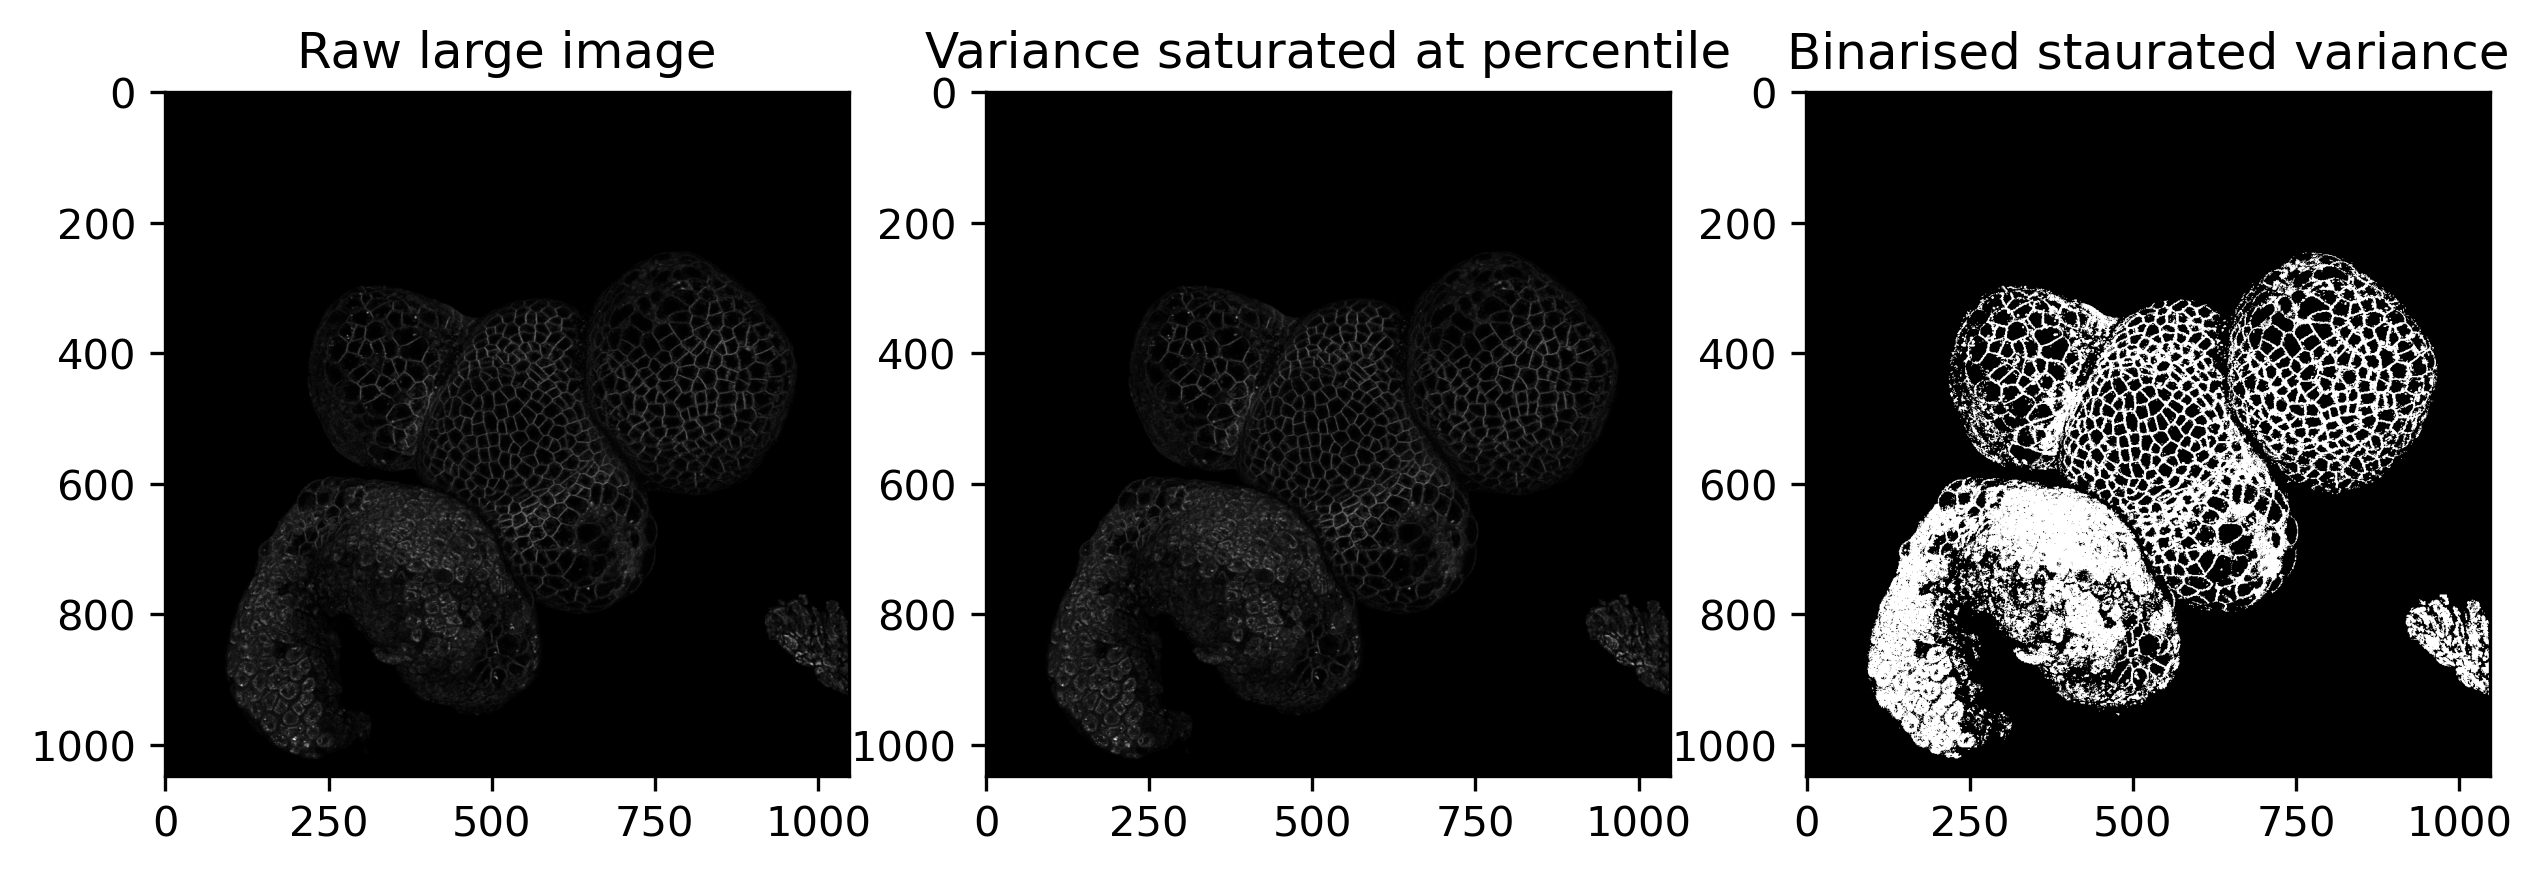

In [17]:
_,axs = plt.subplots(1,3, figsize=(10,20), dpi=300)
axs[0].imshow(im_large_np, cmap='Greys_r')
axs[1].imshow(var, cmap='Greys_r')
axs[2].imshow(var_thr, cmap='Greys_r')

axs[0].set_title('Raw large image')
axs[1].set_title('Variance saturated at percentile')
axs[2].set_title('Binarised staurated variance')


### Resizing images to match pixels

Text(0.5, 1.0, 'Binarised staurated variance (downsampled)')

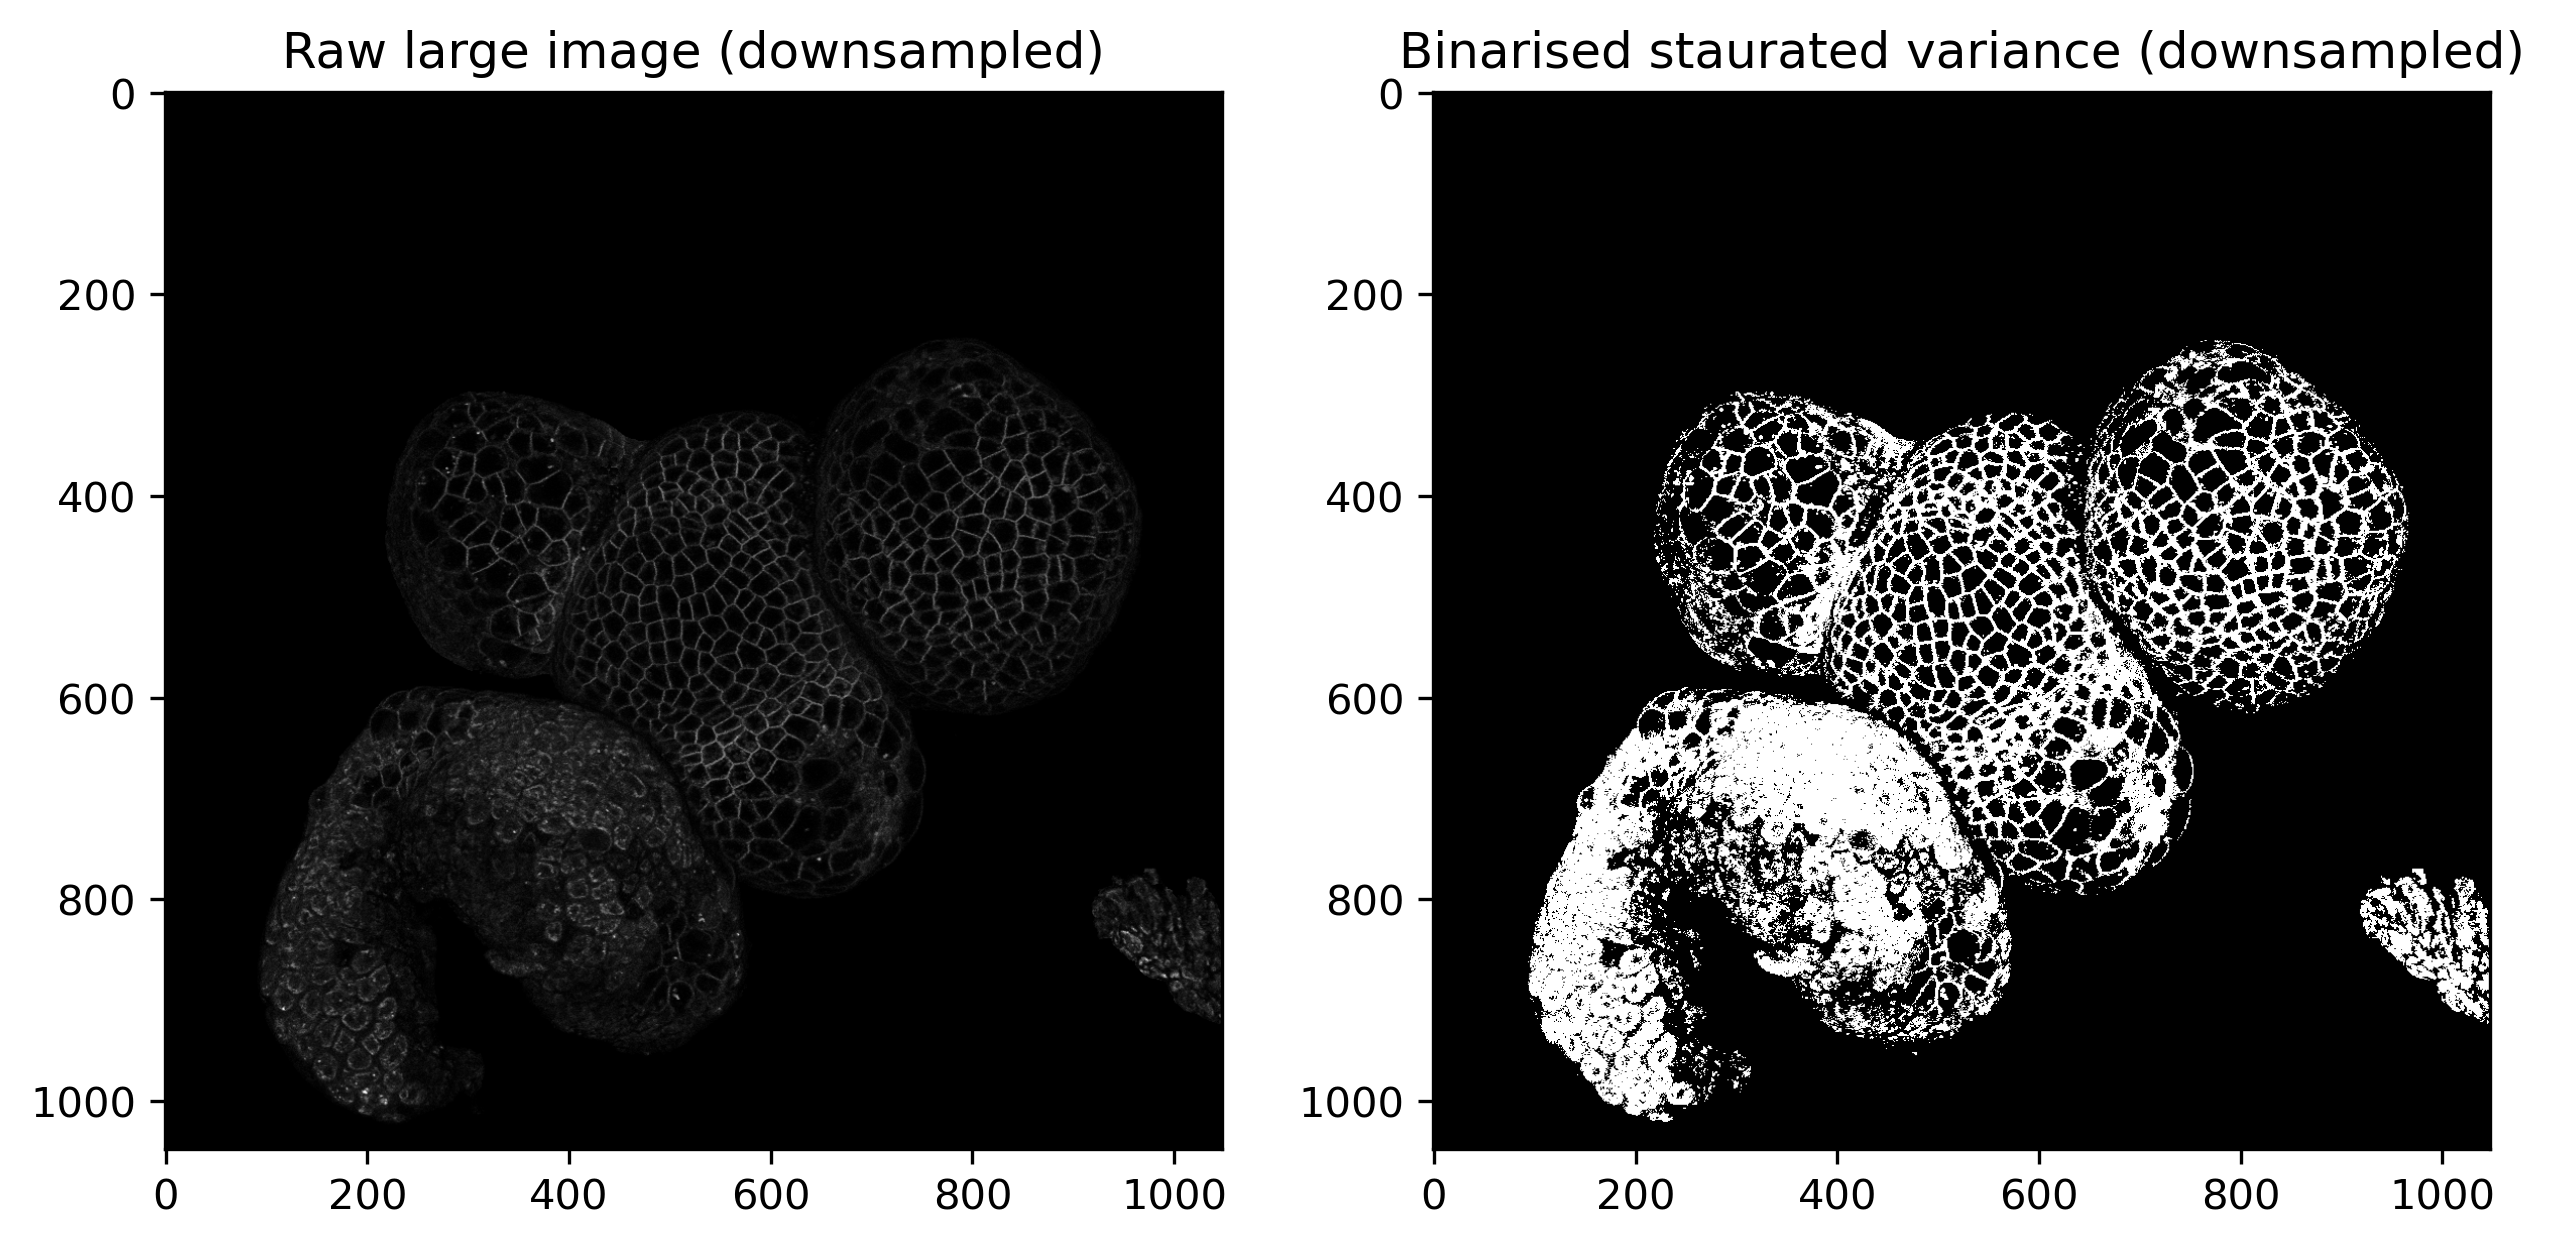

In [18]:
var_thr_downs = var_thr#[::resc_rat,::resc_rat]
im_orig_downs = im_large_np#[::resc_rat,::resc_rat]

_,axs = plt.subplots(1,2, figsize=(10,20), dpi=300)
axs[0].imshow(im_orig_downs, cmap='Greys_r')
axs[1].imshow(var_thr_downs, cmap='Greys_r')

axs[0].set_title('Raw large image (downsampled)')
axs[1].set_title('Binarised staurated variance (downsampled)')


### Trying cross-correlation

In [19]:
x, y= max_cross_corr(var_thr.astype(int), im_small_np_thr.astype(int))

Text(0.5, 1.0, 'Overlay of full small image and large image')

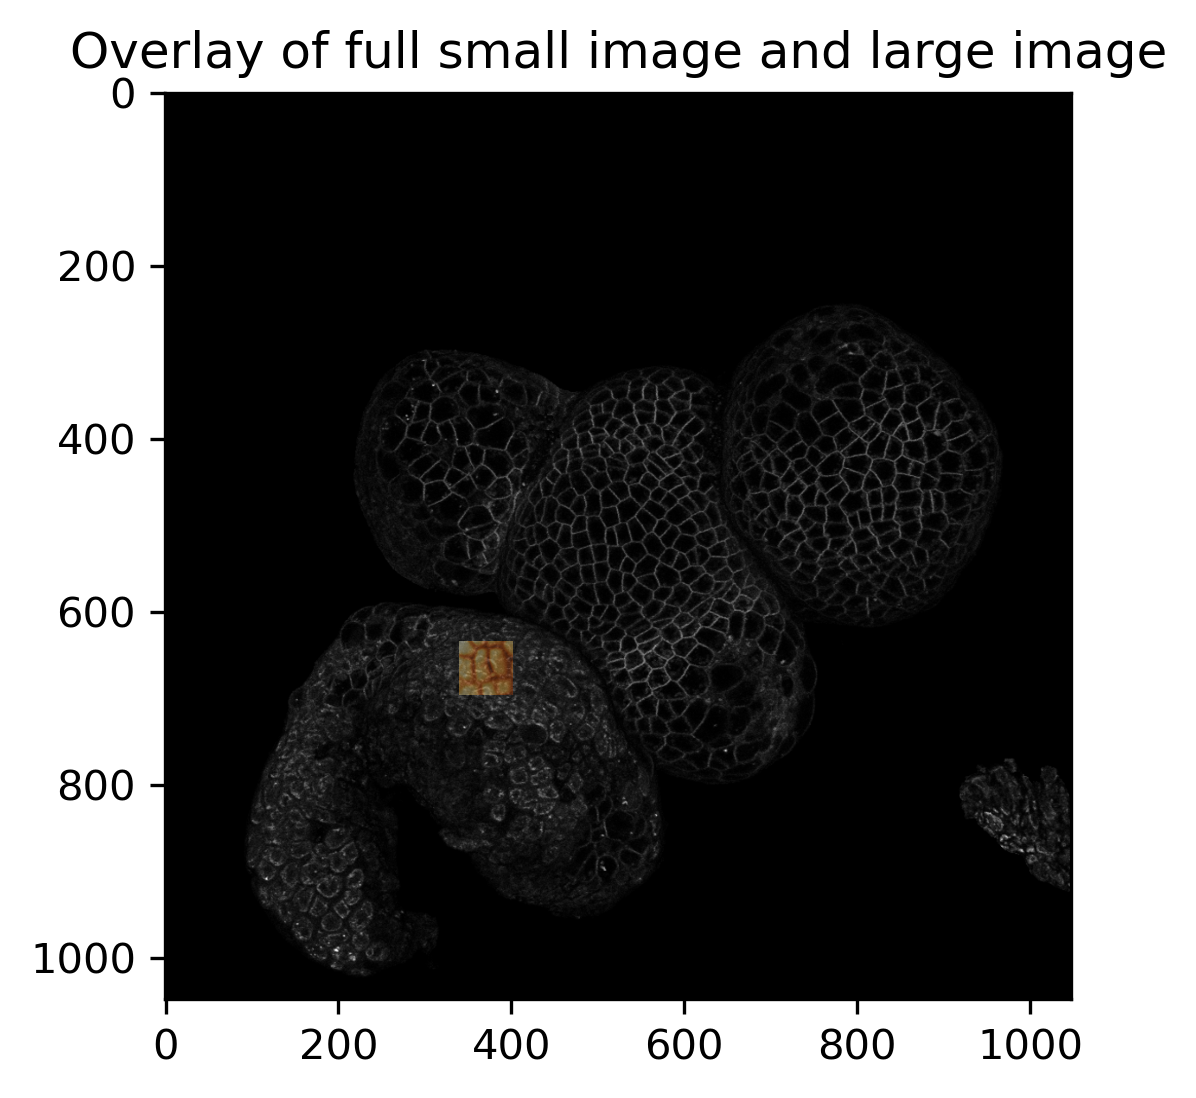

In [20]:
dim = (im_small_np.shape[0], im_small_np.shape[1]) # desired dimensions

overlay = np.zeros(im_large_np.shape)
overlay[:] = np.nan
overlay[x[0]:x[0]+dim[0], y[0]:y[0]+dim[1]] = im_small_np

plt.figure(dpi=300)
plt.imshow(im_large_np, cmap='Greys_r')
plt.imshow(overlay, cmap='YlOrBr',alpha=0.4)
plt.title('Overlay of full small image and large image')